In [1]:
# GLOBAL VARIALBES FOR NOTEBOOK
MLFLOW_TRACKING_URI = "http://localhost:5000"
MLFLOW_EXPERIMENT_NAME = "my-experiment"

SHOW_MAP = False
ALL_DATA_ANALYSS = False

# GLOBAL VARIABLES FOR API
FRIDHEMSPLAN = [59.334438, 18.029522]
SYSTEMBOLAGET = [(59.335187, 18.030381), (59.328920, 18.042743)]
TUNNELBANA = [(59.329788, 18.041727), ( 59.331329, 18.045915 ), 
              ( 59.332202, 18.029171 ), 
              ( 59.334446, 18.032334 ), ( 59.334774, 18.025189 ),
             ( 59.331547, 18.014932 ), ( 59.332835, 18.002897 ),
             ( 59.338285, 18.013849 ), ( 59.336941, 18.017100 ),
             ( 59.339657, 18.036857 )]
CENTRALEN = [(59.330624, 18.057775)]

# https://www.assa.org.au/edm#Index
EASTER_STR = """23rd April 2000   20th April 2025   10th April 2050    7th April 2075
   15th April 2001    5th April 2026    2nd April 2051   19th April 2076
   31st March 2002   28th March 2027   21st April 2052   11th April 2077
   20th April 2003   16th April 2028    6th April 2053    3rd April 2078
   11th April 2004    1st April 2029   29th March 2054   23rd April 2079
   27th March 2005   21st April 2030   18th April 2055    7th April 2080
   16th April 2006   13th April 2031    2nd April 2056   30th March 2081
    8th April 2007   28th March 2032   22nd April 2057   19th April 2082
   23rd March 2008   17th April 2033   14th April 2058    4th April 2083
   12th April 2009    9th April 2034   30th March 2059   26th March 2084
    4th April 2010   25th March 2035   18th April 2060   15th April 2085
   24th April 2011   13th April 2036   10th April 2061   31st March 2086
    8th April 2012    5th April 2037   26th March 2062   20th April 2087
   31st March 2013   25th April 2038   15th April 2063   11th April 2088
   20th April 2014   10th April 2039    6th April 2064    3rd April 2089
    5th April 2015    1st April 2040   29th March 2065   16th April 2090
   27th March 2016   21st April 2041   11th April 2066    8th April 2091
   16th April 2017    6th April 2042    3rd April 2067   30th March 2092
    1st April 2018   29th March 2043   22nd April 2068   12th April 2093
   21st April 2019   17th April 2044   14th April 2069    4th April 2094
   12th April 2020    9th April 2045   30th March 2070   24th April 2095
    4th April 2021   25th March 2046   19th April 2071   15th April 2096
   17th April 2022   14th April 2047   10th April 2072   31st March 2097
    9th April 2023    5th April 2048   26th March 2073   20th April 2098
   31st March 2024   18th April 2049   15th April 2074   12th April 2099"""

from dateutil import parser
EASTER_LIST = [parser.parse(x) for x in EASTER_STR.split("  ") if x]
EASTER_MAP = {d.year: d for d in EASTER_LIST}
CENTER = ",".join([str(x) for x in FRIDHEMSPLAN])
DIM = "500,2000"
LIMIT = 1000
MAX_LIVING_AREA = 55
ENDPOINT = "sold"

#parameters = {"center": CENTER, "dim": DIM, "limit": LIMIT, "maxLivingArea": MAX_LIVING_AREA}
#parameters = {"center": CENTER, "dim": DIM, "limit": LIMIT}
#parameters = {"q": "kungsholmen", "limit": LIMIT, "maxLivingArea": MAX_LIVING_AREA }
parameters = {"q": "kungsholmen", "limit": LIMIT}

In [2]:
%matplotlib inline

import sys
sys.path.append('../')

import itertools
import time

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('seaborn-white')
import pandas as pd
import seaborn as sns
import numpy as np

import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

try:
    import mlflow
    import mlflow.sklearn
    
    mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
    
    MLFLOW = True
except Exception as e:
    print("MLflow won't be used: {}".format(e))
    MLFLOW = False
    
from scipy.stats import norm, skew
from scipy import stats


import boolipy
api = boolipy.api.Api()


The scikit-learn version is 0.21.3.
MLflow won't be used: HTTPConnectionPool(host='localhost', port=5000): Max retries exceeded with url: /api/2.0/mlflow/experiments/get-by-name?experiment_name=my-experiment (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f79445f9940>: Failed to establish a new connection: [Errno 111] Connection refused',))


In [3]:
# return an array of all the requests
data = api.get(endpoint=ENDPOINT, parameters=parameters, follow=True)

In [4]:
# debug data from requests
# flattern data
df = pd.DataFrame.from_dict(data)
#print("Data extracted info: totalCount: {}, limit: {}, offset: {}"data[0])

# Check data

In [5]:
df.shape

(13149, 19)

In [6]:
df.columns

Index(['location', 'rent', 'floor', 'livingArea', 'source', 'rooms',
       'published', 'constructionYear', 'objectType', 'booliId', 'soldDate',
       'soldPrice', 'apartmentNumber', 'soldPriceSource', 'url', 'listPrice',
       'additionalArea', 'plotArea', 'isNewConstruction'],
      dtype='object')

In [7]:
# define how do we want to change the data
from haversine import haversine, Unit


def location_tuple(x): 
    loc = x['location']['position']
    return [loc['latitude'], loc['longitude']]
def source_name(x): return x["source"]["name"]
def norm_price(x): return x["soldPrice"]/x["livingArea"]

def time_published(x): return x["soldDate"]-x["published"]
def source_name(x): return x["source"]["name"]
def price_increased(x): return x["soldPrice"] - x["listPrice"]
# convert location to tuple
def location_tuple(x): 
    loc = x['location']['position']
    return (loc['latitude'], loc['longitude'])

def dist_points(x, pois):
    def to_tuple(p):
        if isinstance(p, str):
            return tuple([float(l) for l in p.split(',')])
        return p
    
    if isinstance(x, dict) or isinstance(x, pd.Series):
        c = x['loc_tuple']    
    else:
        c = tuple([float(l) for l in x.split(',')])
    
    return min([haversine(c, poi, unit=Unit.METERS) for poi in pois])

def dist_system(x): return dist_points(x, SYSTEMBOLAGET)
def dist_tunnelbana(x): return dist_points(x, TUNNELBANA)


def street_name(x):
    import re
    address = x['location']['address']['streetAddress']
    # remove the number
    return re.sub("(\s\d+\w?)", '', address)

def street_number(x):
    import re
    address = x['location']['address']['streetAddress']
    # remove the number
    return re.sub("(.*\s)", '', address)

def log_transform(feature, x=None):
    if x is None:
        x = ddf

    return np.log1p(x[feature].values)

def quadratic(feature, x=None):
    if x is None:
        x = ddf
    return x[feature]**2

def dist_easter(x):
    dt = x.to_pydatetime()
    return (dt - EASTER_MAP[dt.year]).days
    
    
    
df['loc_tuple'] = df.apply(location_tuple, axis=1)
df['source_name'] = df.apply(source_name, axis=1)
df['norm_price'] = df.apply(norm_price, axis=1)

df['soldDate'] = pd.to_datetime(df['soldDate'], format="%Y-%m-%d") 
df['soldQuarter'] = df['soldDate'] + pd.offsets.QuarterBegin(n=0)
df['soldYear'] = df['soldDate'].apply(lambda x: x.year)
df['soldMonth'] = df['soldDate'].apply(lambda x: x.month)

df['street_name'] = df.apply(street_name, axis=1)
df['street_number'] = df.apply(street_number, axis=1)

df['published'] = pd.to_datetime(df['published']) 

df['time_published'] = df.apply(time_published, axis=1)
df['source_name'] = df.apply(source_name, axis=1)
df['price_increased'] = df.apply(price_increased, axis=1)

df['hasBalcony'] = df['additionalArea'].apply(lambda x: 1 if x > 0 else 0)

# Convert numeric variables to categorical
df['soldYear'] = df['soldYear']
df['soldMonth'] = df['soldMonth']
df['constructionYear'] = df['constructionYear']

# Distances
df['dist_tunnelbana'] = df.apply(dist_tunnelbana, axis=1)
df['dist_system'] = df.apply(dist_system, axis=1)
df['dist_ocean'] = df.apply(lambda x: x['location'].get('distance', {}).get('ocean', None), axis=1)

#df['dist_easter'] = df['soldDate'].apply(dist_easter)


<>:40: DeprecationWarning: invalid escape sequence \s
<>:46: DeprecationWarning: invalid escape sequence \s
<>:40: DeprecationWarning: invalid escape sequence \s
<>:46: DeprecationWarning: invalid escape sequence \s
<>:40: DeprecationWarning: invalid escape sequence \s
<>:46: DeprecationWarning: invalid escape sequence \s
<ipython-input-7-73ac546e07e9>:40: DeprecationWarning: invalid escape sequence \s
  return re.sub("(\s\d+\w?)", '', address)
<ipython-input-7-73ac546e07e9>:46: DeprecationWarning: invalid escape sequence \s
  return re.sub("(.*\s)", '', address)


In [8]:
## DEFINES VARIABLES FOR MODEL
boolean_vars = ["hasBalcony"]
discrete_vars = ["rooms", "floor", "soldYear", "soldMonth", "constructionYear"]
categorical_vars = ["street_name", "street_number"]
quantitative_vars = ["livingArea", "dist_tunnelbana", "dist_system"]

features = quantitative_vars + discrete_vars + boolean_vars + categorical_vars
target = "soldPrice"
sorted_by = "soldDate"


In [9]:
#print("Unique Quarters: {}".format(len(df['soldQuarter'].unique())))
#print("Unique sources of info: {}".format(df['source_name'].unique()))
#print("Unique streets of info: {}".format(df['street'].unique()))

# Plot apartments

In [10]:
if SHOW_MAP:
    import folium

    # zoom_start as a function of the dim?

    m = folium.Map(
        location=FRIDHEMSPLAN,
        zoom_start=14
    )


    #folium.Marker(FRIDHEMSPLAN, popup='Center of the univers').add_to(m)

    def get_popup_str(x): 
        return '{} </br> size: {} </br> price: {} </br> date: {}'.format(x['location']['address']['streetAddress'], x['livingArea'], x['soldPrice'], x['soldDate'])

    for index, row in df.iterrows():
        folium.Marker(row['loc_tuple'], popup=get_popup_str(row)).add_to(m)

    m



# Analize our soldPrice
Getting guide from https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python

In [11]:
TARGET = 'soldPrice' 
df[TARGET].describe()

count    1.314900e+04
mean     4.379404e+06
std      2.050238e+06
min      1.400000e+06
25%      2.990000e+06
50%      3.760000e+06
75%      5.300000e+06
max      2.930000e+07
Name: soldPrice, dtype: float64

In [12]:
df['soldDate'].describe()


count                   13149
unique                   2235
top       2016-10-13 00:00:00
freq                       32
first     2012-08-29 00:00:00
last      2019-12-09 00:00:00
Name: soldDate, dtype: object

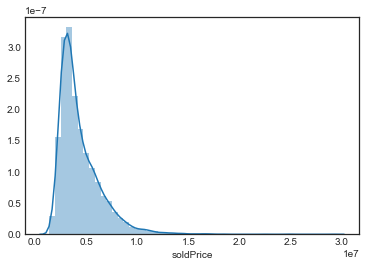

In [13]:
sns.distplot(df[TARGET]);

In [14]:
#skewness and kurtosis
print("Skewness: %f" % df['soldPrice'].skew())
print("Kurtosis: %f" % df['soldPrice'].kurt())

Skewness: 2.023043
Kurtosis: 7.862638


## Relationship with numerical variables

In [15]:
df.columns
num_variables = ['livingArea', 'listPrice', 'rent', 'soldDate', 'dist_ocean', 'dist_system']

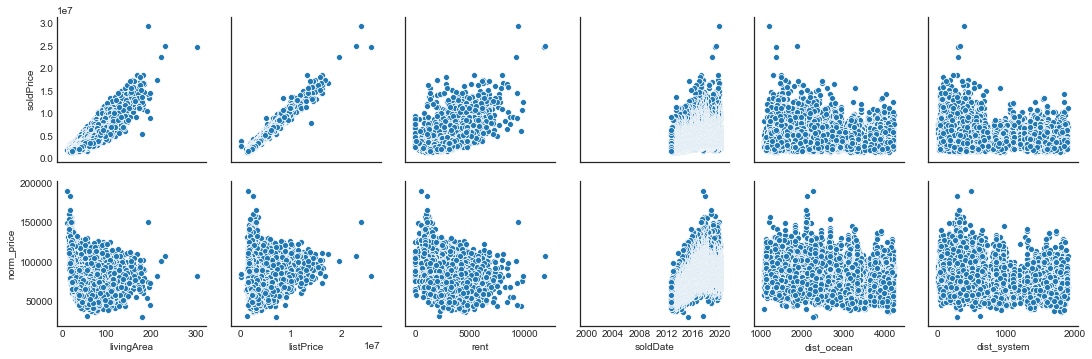

In [16]:
sns.pairplot(df, x_vars=num_variables, y_vars=[TARGET, 'norm_price'])

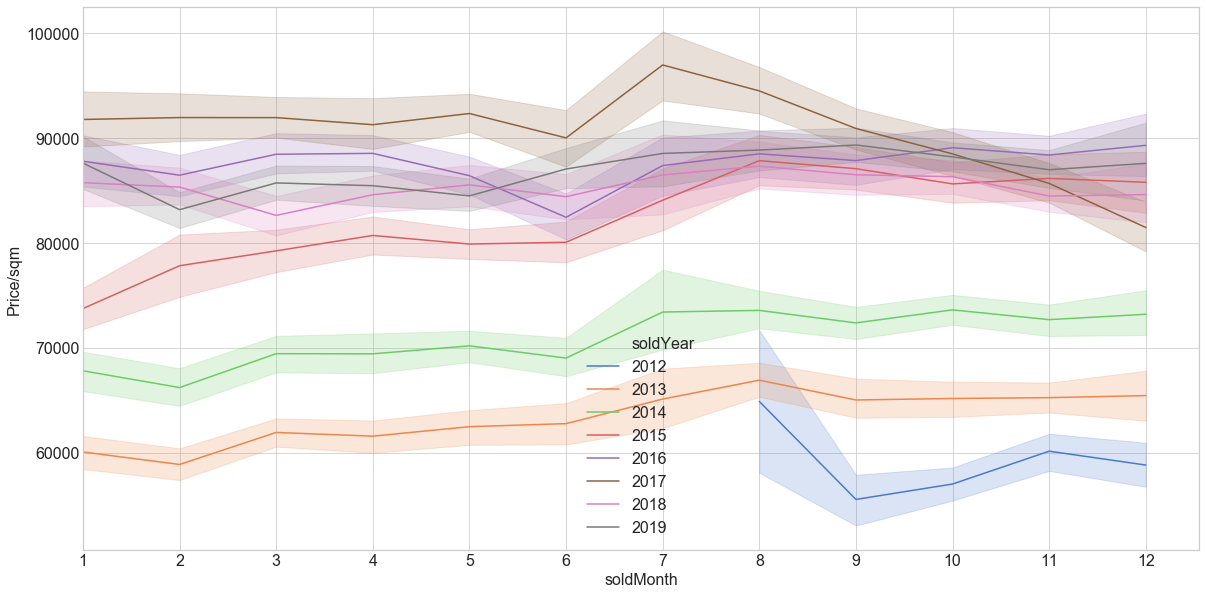

In [17]:
FONT_SIZE=16
rc={'axes.labelsize': FONT_SIZE, 'font.size': FONT_SIZE, 
    'legend.fontsize': FONT_SIZE, 'axes.titlesize': FONT_SIZE, 
    'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)

plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")
years = df['soldYear'].unique()
palette_years = sns.color_palette("muted", years.shape[0])
f = ax = sns.lineplot(data=df, x='soldMonth', y='norm_price', hue="soldYear", palette=palette_years)
ax.set_xlim(min(df['soldMonth']),)
ax.set_ylabel("Price/sqm")

ax.set_xticks(np.arange(1,13,1));

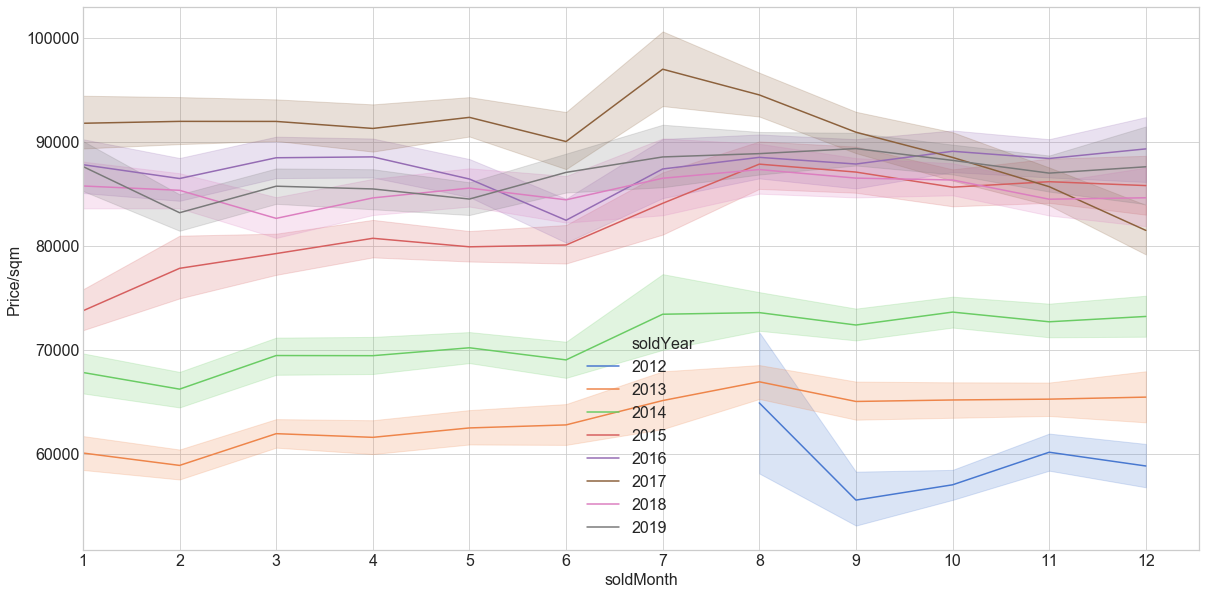

In [18]:
FONT_SIZE=16
rc={'axes.labelsize': FONT_SIZE, 'font.size': FONT_SIZE, 
    'legend.fontsize': FONT_SIZE, 'axes.titlesize': FONT_SIZE, 
    'xtick.labelsize': FONT_SIZE, 'ytick.labelsize': FONT_SIZE}
plt.rcParams.update(**rc)

plt.figure(figsize=(20, 10))
sns.set_style("whitegrid")
years = df['soldYear'].unique()
palette_years = sns.color_palette("muted", years.shape[0])
f = ax = sns.lineplot(data=df, x='soldMonth', y='norm_price', hue="soldYear", palette=palette_years)
ax.set_xlim(min(df['soldMonth']),)
ax.set_ylabel("Price/sqm")

ax.set_xticks(np.arange(1,13,1));

(734744.0, 737766.1103494624)

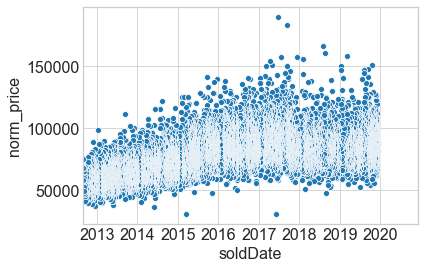

In [19]:
f = ax = sns.scatterplot(data=df, x='soldDate', y='norm_price')
ax.set_xlim(min(df['soldDate']),)

(734744.0, 737766.1031048388)

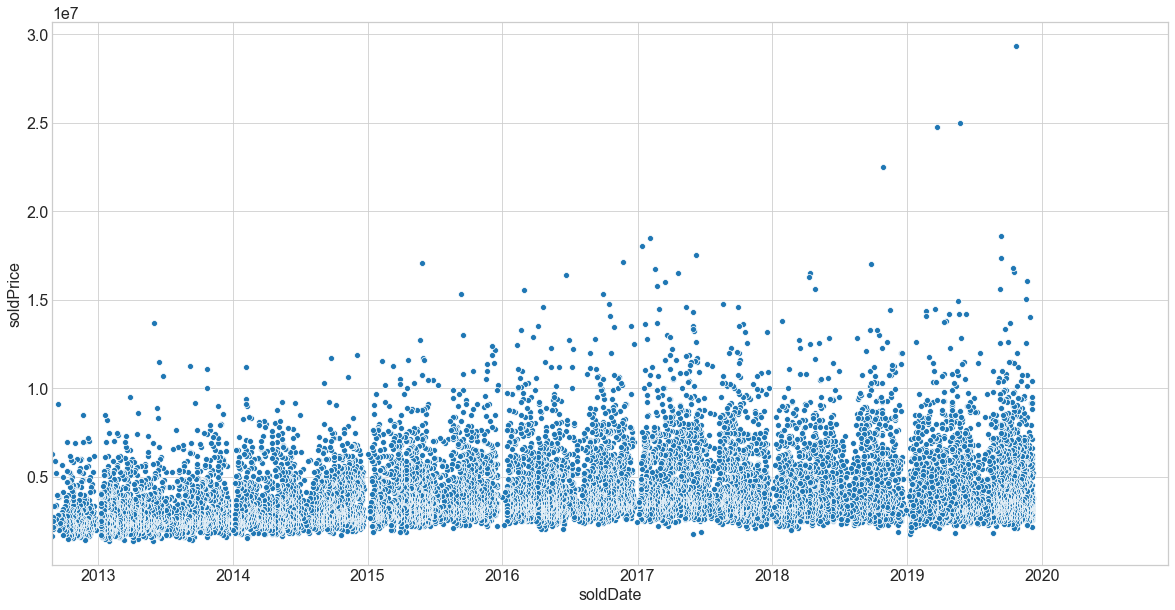

In [20]:
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=df, x='soldDate', y='soldPrice')

ax.set_xlim(min(df['soldDate']),)

(734747.0, 737853.2531048388)

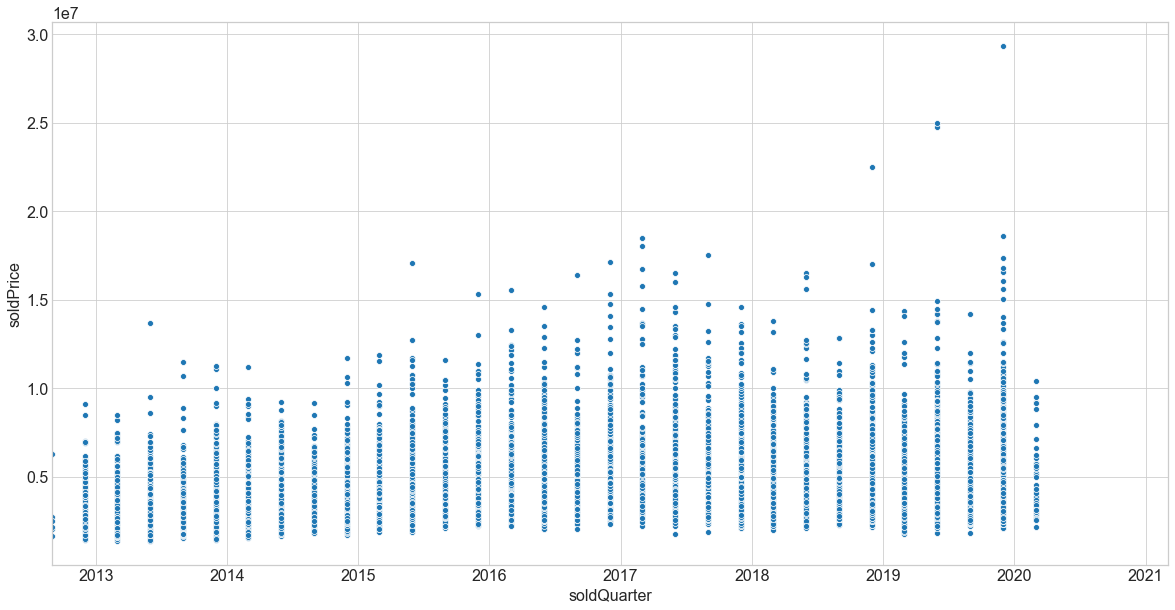

In [21]:
plt.figure(figsize=(20, 10))
ax = sns.scatterplot(data=df, x='soldQuarter', y='soldPrice')

ax.set_xlim(min(df['soldQuarter']),)

# Relationship with categorical variables?

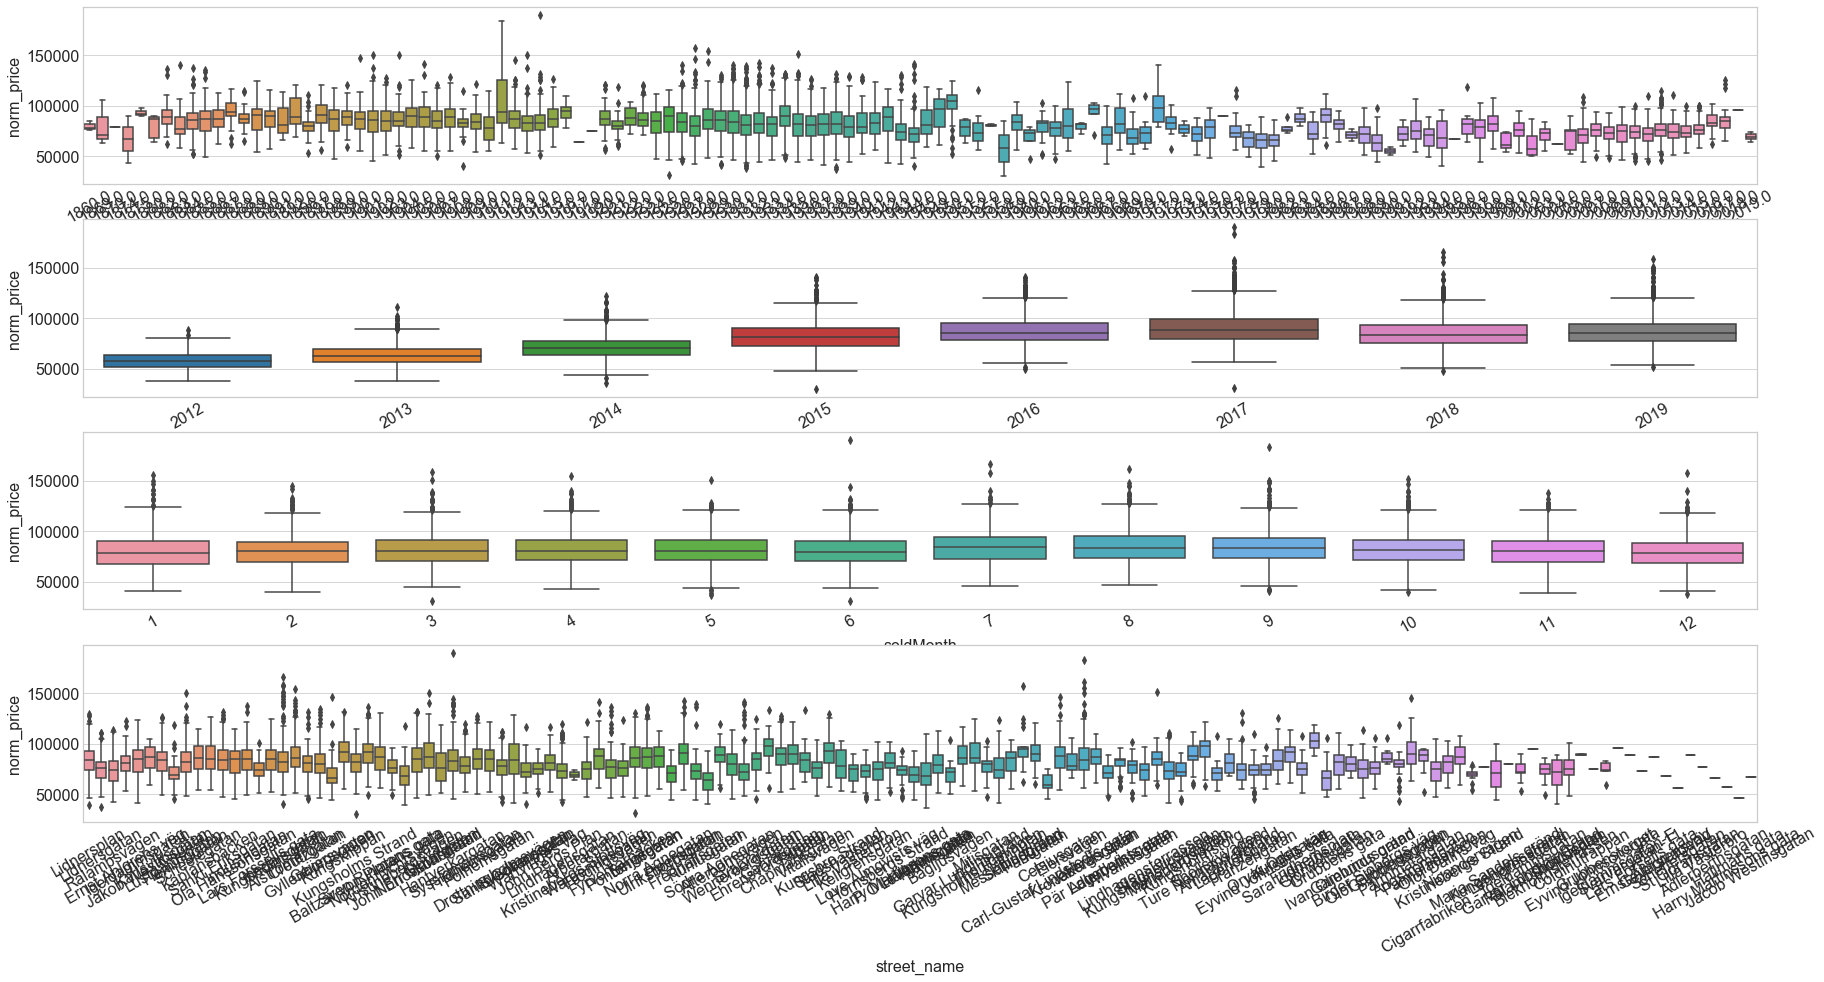

In [22]:
from datetime import datetime
cat_variables = ['constructionYear', 'soldYear', 'soldMonth', 'street_name']

fig, axes = plt.subplots(len(cat_variables), 1, figsize=(30,15))
axes = axes.flatten()

def draw_limit(ax):
    ax.axvline(x=datetime(year=2015, month=1, day=1), ls=":", c=".2")
    
i = 0
for t in cat_variables:
    ax = sns.boxplot(x=t, y="norm_price", data=df, orient='v', ax=axes[i])
    #draw_limit(ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    #ax.set_xticklabels(rotation=30)
    i +=1

# Objective analysis

In [23]:
# remove variables which we are not interested in
df_corr = df.copy()
df_corr.drop(columns=["additionalArea", "plotArea", 
                      "booliId", "apartmentNumber", "listPrice", 
                      "price_increased"], inplace=True)

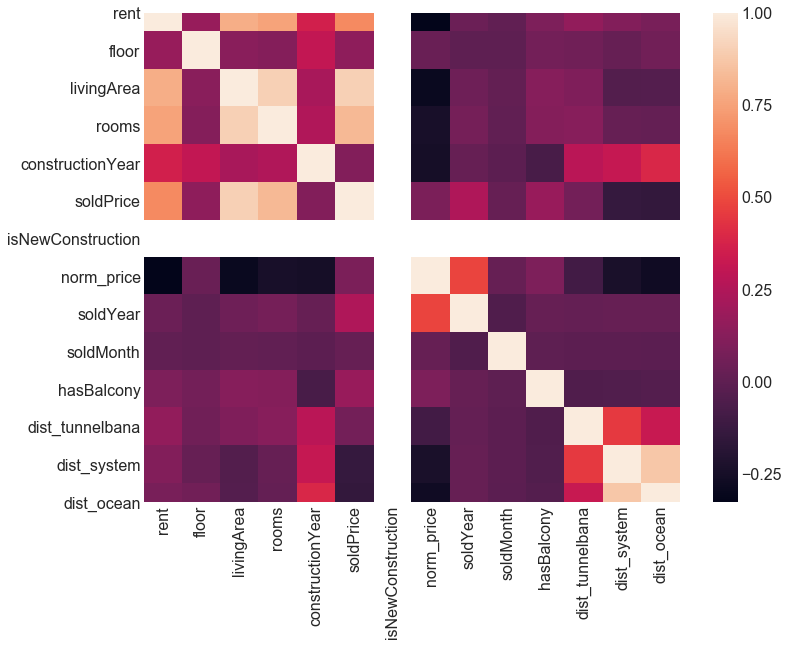

In [24]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df_corr.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat)

# Deal with missing data


In [25]:
ddf = df[features + [target]  + [sorted_by]]

def missing_data(tdf):
    total = ddf.isnull().sum().sort_values(ascending=False)
    percent = 100*(ddf.isnull().sum()/ddf.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data
    
missing_data(ddf).head(20)

,Total,Percent
constructionYear,1330,10.114838
floor,1217,9.255457
livingArea,30,0.228154
rooms,21,0.159708
soldDate,0,0.000000
soldPrice,0,0.000000
street_number,0,0.000000
street_name,0,0.000000
hasBalcony,0,0.000000
soldMonth,0,0.000000


In [26]:
#dealing with missing data
# we don't want to remove the floor feature since it makes some impact
# let's use the median
ddf['floor'] = ddf['floor'].replace(np.nan, ddf['floor'].median())
ddf['constructionYear'] = ddf['constructionYear'].replace(np.nan, ddf['constructionYear'].median())
ddf = ddf.drop(ddf.loc[ddf['rooms'].isnull()].index)
ddf = ddf.drop(ddf.loc[ddf['livingArea'].isnull()].index)
#ddf = ddf.drop(ddf.loc[ddf['dist_ocean'].isnull()].index)

#ddf = ddf.drop(ddf.loc[ddf['norm_price'].isnull()].index)


# remove outliers
ddf = ddf.drop(ddf.loc[ddf['floor'] > 20].index)

missing_data(ddf).head(20)
print("New data shape: {}".format(ddf.shape))
print("Columns not filtered: {}".format(ddf.columns.values))

New data shape: (13108, 13)
Columns not filtered: ['livingArea' 'dist_tunnelbana' 'dist_system' 'rooms' 'floor' 'soldYear'
 'soldMonth' 'constructionYear' 'hasBalcony' 'street_name' 'street_number'
 'soldPrice' 'soldDate']


## global pairplot

In [27]:
#cols = quantitative_vars + discrete_vars + ['soldPrice']
#sns.pairplot(ddf, vars=cols)

# In the search for normality

The point here is to test 'SalePrice' in a very lean way. We'll do this paying attention to:

    Histogram - Kurtosis and skewness.
    Normal probability plot - Data distribution should closely follow the diagonal that represents the normal distribution.


In [28]:
import scipy.stats as st

def is_normal(_df, _vars):
    test_normality = lambda x: stats.shapiro(x.fillna(0))[1] < 0.01
    normal = pd.DataFrame(_df[_vars])
    normal = normal.apply(test_normality)
    return not normal.any()

def plot_hist_prob(_df, var_test, transform=None):
    #histogram and normal probability plot
    if transform is None:
        transform = lambda x: x
    sns.distplot(_df[var_test].apply(transform), fit=norm);
    fig = plt.figure()
    res = stats.probplot(_df[var_test], plot=plt)
    
def check_dist_fit(_df, name):
    _y = _df[name].dropna()
    plt.figure(1); plt.title(name + ' Johnson SU')
    sns.distplot(_y, kde=False, fit=st.johnsonsu)
    plt.figure(2); plt.title(name + ' Normal')
    sns.distplot(_y, kde=False, fit=st.norm)
    plt.figure(3); plt.title(name + ' Log Normal')
    sns.distplot(_y, kde=False, fit=st.lognorm)

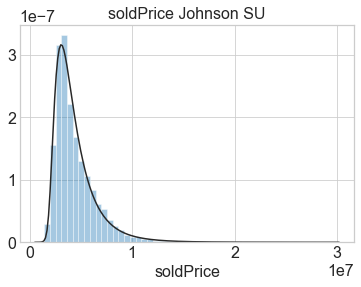

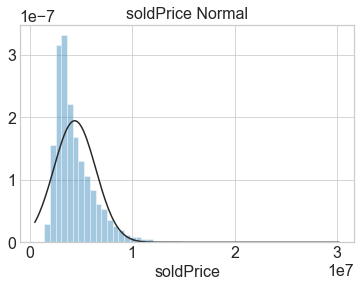

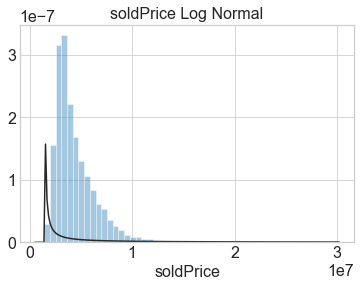

In [29]:
check_dist_fit(df, 'soldPrice')

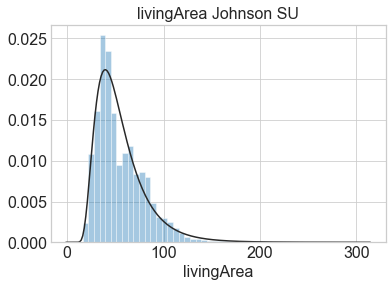

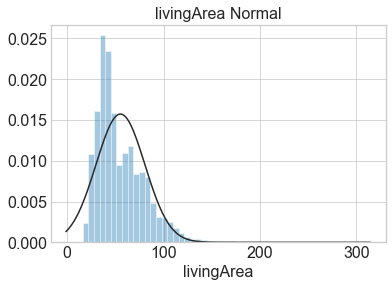

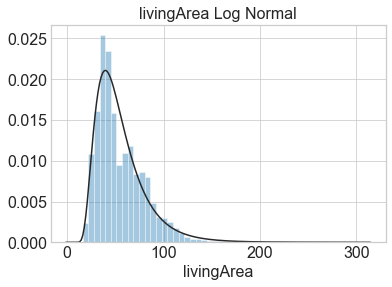

In [30]:
check_dist_fit(df, 'livingArea')

Target is not normal. Apply log_transform
Is normal after transformation? False


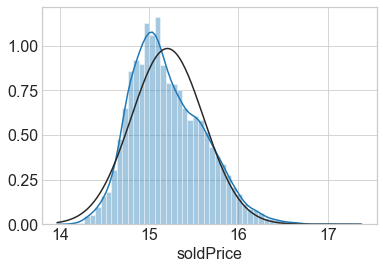

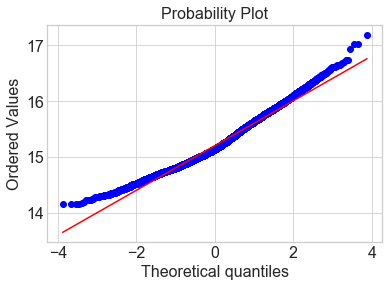

In [31]:
if not is_normal(ddf, ["soldPrice"]):
    print("Target is not normal. Apply log_transform")
    ddf["soldPrice"] = log_transform("soldPrice", ddf)
    plot_hist_prob(ddf, "soldPrice")

    print("Is normal after transformation? {}".format(is_normal(ddf, ["soldPrice"])))
else:
    print("Is normal? {}".format(is_normal(ddf, ["soldPrice"])))


Skewness: 1.336302
Kurtosis: 3.037273


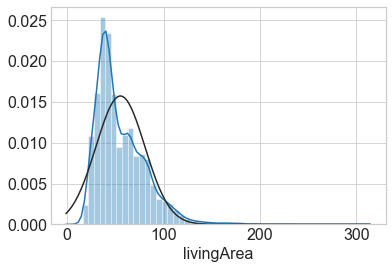

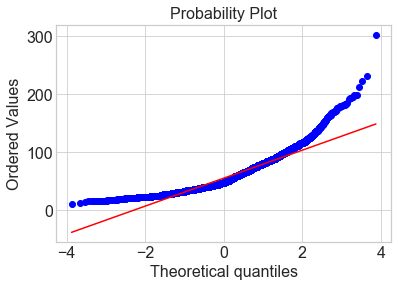

In [32]:
plot_hist_prob(ddf, "livingArea")
#skewness and kurtosis
print("Skewness: %f" % ddf['livingArea'].skew())
print("Kurtosis: %f" % ddf['livingArea'].kurt())

In [33]:
# Check the skew of all numerical features

skewed_feats = ddf[quantitative_vars].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
livingArea,1.336149
dist_system,0.800499
dist_tunnelbana,0.561622


In [34]:
skewness = skewness[abs(skewness) > 0.75].dropna()
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))
from scipy.special import boxcox1p
skewed_features = skewness.index

#https://machinelearningmastery.com/how-to-transform-data-to-fit-the-normal-distribution/
#    lambda = -1. is a reciprocal transform.
#    lambda = -0.5 is a reciprocal square root transform.
#    lambda = 0.0 is a log transform.
#    lambda = 0.5 is a square root transform.
#    lambda = 1.0 is no transform.

ddfs = ddf.copy()

lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    print("apply to {}".format(feat))
    ddfs[feat] = boxcox1p(ddfs[feat], lam)

There are 2 skewed numerical features to Box Cox transform
apply to livingArea
apply to dist_system


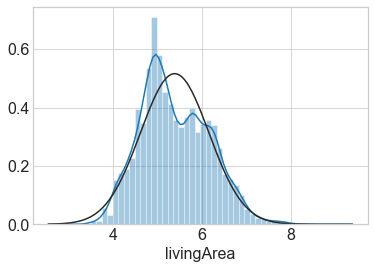

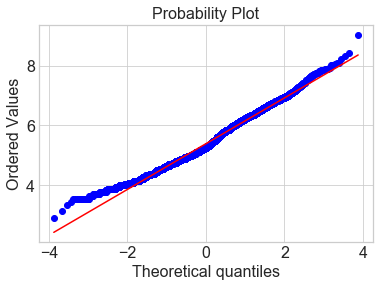

In [35]:
plot_hist_prob(ddfs, "livingArea")

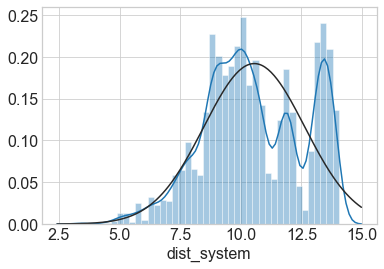

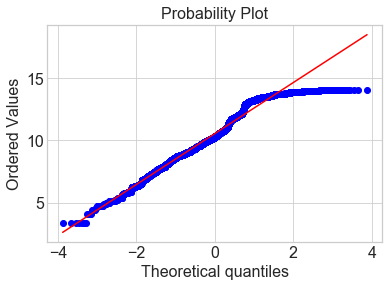

In [36]:
plot_hist_prob(ddfs, "dist_system")

# Build model

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

import xgboost as xgb
import lightgbm as lgb

## Prepare data for the model

In [38]:
# create training and testing vars
# df: original data
# ddf: orginal data - nulls and outliers
# ddfs: orgininal with transform boxcop
# ddft: original data - null and outliers - log transform (on soldPrice)
x = ddfs.copy()
    
feature_names = sorted(pd.Series(features))

# we sorted by soldDate since it's the order we want when using our TimeSeries CV
x = x.sort_values(by="soldDate")

In [39]:
y = x[target] # define the target variable (dependent variable) as y
x = x[feature_names]
print("Columns order: {}".format(x.columns))

Columns order: Index(['constructionYear', 'dist_system', 'dist_tunnelbana', 'floor',
       'hasBalcony', 'livingArea', 'rooms', 'soldMonth', 'soldYear',
       'street_name', 'street_number'],
      dtype='object')


In [40]:
# apply preprocessing to all
from sklearn.preprocessing import FunctionTransformer

# Apply scaler
numeric_transformer = Pipeline(steps=[('scaler', RobustScaler())])

# One hot encoder
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer( remainder='passthrough',
    transformers=[
        ('num', numeric_transformer, quantitative_vars),
        ('cat', categorical_transformer, categorical_vars)])

preprocessor_pipeline = Pipeline(steps=[('preprocessor', preprocessor), 
                                        ('todense', FunctionTransformer(lambda x: x.todense(), accept_sparse=True), )])
preprocessor_pipeline.fit(x)

x = preprocessor_pipeline.transform(x)
#dir(preprocessor_pipeline)

## Regression methods
* Linear
* Logistic
* Polynomial
* ElasticNet
* Ridge
* Lasso
https://www.analyticsvidhya.com/blog/2015/08/comprehensive-guide-regression/
    
More regressors using scikit learn: 
    * https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble
    * https://scikit-learn.org/stable/modules/classes.html#module-sklearn.kernel_ridge
    * https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

In [41]:
# Perform the Kfold score analysis
CV_SCORE=True
# Perform the Kfold for all models
ALL_MODELS_SCORE=False

# Fit all models
ALL_MODELS_FIT=False

# Perform the Grid Search on selected models
SELECTED_GRID_SEARCH=True

### Normalize data
https://towardsdatascience.com/scale-standardize-or-normalize-with-scikit-learn-6ccc7d176a02

### Base models

#### Linear regression models

In [42]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


# ElasticNet
en = ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3)
#en.fit(X_train, y_train)

# Lasso
lassoIc = LassoLarsIC()
#lassoIc.fit(X_train, y_train)
                 
# Lasso
lasso = Lasso(alpha =0.0005, random_state=1)
#lasso.fit(X_train, y_train)

# BayesianRidge
ridge = BayesianRidge()
#ridge.fit(X_train, y_train)

# Kernel Ridge
krr = KernelRidge()
#krr.fit(X_train, y_train)


linear_models = {"ElasticNet": en, "LassoLarsIC": lassoIc, 
                 "Lasso": lasso, "BayesianRidge": ridge,
                 "KernelRidge": krr}

### Ensemble models

In [43]:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor


# Random Forest
rfr = RandomForestRegressor(max_depth=4, random_state=0, n_estimators=600)
#rfr.fit(X_train, y_train)


# AdaBoost
rng = np.random.RandomState(1)
abr = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),
                                 n_estimators=300, random_state=rng)
#abr.fit(X_train, y_train)


# Gradient Boosting
params = {'n_estimators': 1000, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
gbr = GradientBoostingRegressor(**params)
#gbr.fit(X_train, y_train)


ensemble_models = {"RandomForestRegressor": rfr, 
                   "AdaBoostRegressor": abr, "GradientBoostingRegressor": gbr}

In [44]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgb

# XGBoosting

params = {'colsample_bytree': 0.9606895670866631, 
          'gamma': 0.026620140772716794, 
          'learning_rate': 0.11046030263179152, 
          'max_depth': 2, 'n_estimators': 253, 
          'subsample': 0.6179109168365381}
params.update({"objective": "reg:squarederror"})
xgb = XGBRegressor(**params)
#xgb.fit(X_train, y_train)
#evallist = [(dtest, 'eval'), (dtrain, 'train')]

# from GridCV search
params = {'learning_rate': 0.1, 'max_bin': 100, 'n_estimators': 2000, 'num_iterations': 200}
lgbr = LGBMRegressor(**params)
#lgbr.fit(X_train, y_train)


other_models = {"XGBoosting": xgb, "Lightgbm": lgbr}
selected_model = {"Lightgbm": lgbr}

all_models = {**linear_models, **ensemble_models, **other_models}

## Evaluate the models
* API: https://scikit-learn.org/stable/modules/classes.html#regression-metrics
* Doc: https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics

#### Split data train/test for simple validation

In [45]:
# x and y are sorted by date
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=False)
print("Train shapes: ", X_train.shape, y_train.shape)
print("Test shapes: ", X_test.shape, y_test.shape)
print("Features selected: {}".format(features))

Train shapes:  (10486, 456) (10486,)
Test shapes:  (2622, 456) (2622,)
Features selected: ['livingArea', 'dist_tunnelbana', 'dist_system', 'rooms', 'floor', 'soldYear', 'soldMonth', 'constructionYear', 'hasBalcony', 'street_name', 'street_number']


### Base model scores

In [46]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.model_selection import TimeSeriesSplit

### Use cross-validation based on RMSLE
#Validation function
n_folds = 5
# Options for CV_METHOD = {kfold, tsfold}
CV_METHOD = "tsfold"

def cv_method(dtrain, ytrain, method):
    if "kfold" in method:
        return kfold_default(dtrain, ytrain)
    elif "tsfold" in method:
        return TimeSeriesSplit(n_splits=n_folds)
    
def kfold_default(dtrain, ytrain): 
    return KFold(n_folds, shuffle=False, random_state=42).get_n_splits(dtrain)
 
def rmsle_cv(model, dtrain, ytrain, method=CV_METHOD):
    cv = cv_method(dtrain, ytrain, method)
    rmse= np.sqrt(-cross_val_score(model, dtrain, ytrain, scoring="neg_mean_squared_error", cv = cv))
    return(rmse)

def print_score(name, regressor, X_test, y_test):
    print("{:>30} - score: {:>20}".format(name, regressor.score(X_test, y_test)))
    
def get_print_base_score(n, r, dtrain, ytrain):
    # apply preprocessing
    t0 = time.time()
    score = rmsle_cv(r, dtrain, ytrain)
    print("{:>30} score: {:.4f} (std: {:.4f}) in {} s".format(n, score.mean(), score.std(), time.time()-t0))
    
def print_metrics(name, y_true, y_pred):
    def printp(args): print("{:>30} - ".format(name)+args)
    mae = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    msle = metrics.mean_squared_log_error(y_true, y_pred)
    meae = metrics.median_absolute_error(y_true, y_pred)
    evs = metrics.explained_variance_score(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)
    
    printp("mean_absolute_error:      {:>30} (better 0)".format(mae))
    printp("mean_squared_error:       {:>30} (better 0)".format(mse))
    printp("mean_squared_log_error:   {:>30} (better 0)".format(msle))
    printp("median_absolute_error:    {:>30} (better 0)".format(meae))
    
    printp("explained_variance_score: {:>30} (better 1)".format(evs))
    printp("r2_score:                 {:>30} (better 1)".format(r2))
    
    if MLFLOW:
        mlflow.log_metric("mean_absolute_error", mae)
        mlflow.log_metric("mean_squared_error", mse)
        mlflow.log_metric("mean_squared_log_error", msle)
        mlflow.log_metric("median_absolute_error", meae)
        mlflow.log_metric("explained_variance_score", evs)
        mlflow.log_metric("r2_score", r2)


In [47]:
if CV_SCORE and ALL_MODELS_SCORE:
    print("=================== Linear models (CV - {}) ===================".format(CV_METHOD))
    for n, r in linear_models.items():
        get_print_base_score(n, r, x, y)

    print("=================== Ensemble models (CV - {}) ===================".format(CV_METHOD))
    for n, r in ensemble_models.items():
        get_print_base_score(n, r, x, y)

    print("=================== Other models (CV - {}) ===================".format(CV_METHOD))
    for n, r in other_models.items():
        get_print_base_score(n, r, x, y)
        
if CV_SCORE and SELECTED_GRID_SEARCH:
    for n, r in selected_model.items():
        get_print_base_score(n, r, x, y)

                      Lightgbm score: 0.1106 (std: 0.0225) in 1.4629850387573242 s


In [48]:
from scipy.stats import uniform, randint

if SELECTED_GRID_SEARCH:
    best_selected_model = {}
    # use GridSearchCV
    for n, r in selected_model.items():
        # https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
        # For better accuracy
        # Use large max_bin (may be slower)
        # Use small learning_rate with large num_iterations
        # Use large num_leaves (may cause over-fitting)
        # Use bigger training data
        # Try dart

        # Important features: num_leaves, bins, feature_fraction, 
        #bagging_fraction, min_data_in_leaf, min_sum_hessian_in_leaf and few others.
        if "Lightgbm" in n:
            param_grid = {
                'learning_rate': [0.01, 0.1, 1],
                'n_estimators': [100, 500, 2000],
                'num_iterations': [200, 400, 500],
                'max_bin': [10, 50, 100, 200]
            }
        elif "XGBoosting" in n:
            param_grid = {
                "colsample_bytree": uniform(0.7, 0.3),
                "gamma": uniform(0, 0.5),
                "learning_rate": uniform(0.03, 0.3), # default 0.1 
                "max_depth": randint(2, 6), # default 3
                "n_estimators": randint(300, 700), # default 100
                "subsample": uniform(0.6, 0.4)
            }
            
        inner_cv = cv_method(x, y, method=CV_METHOD)
        
        #rcv = RandomizedSearchCV(r, param_grid, cv=inner_cv, n_iter = 10, verbose=False)
        rcv = GridSearchCV(r, param_grid, cv=inner_cv)
        rcv.fit(X_train, y_train)                   
            
        print('Best parameters found by grid search are:', rcv.best_params_)
        print('Best score found by grid search are:', rcv.best_score_)

        nn = n + "-grid"
        print_metrics(nn, y_test, rcv.predict(X_test))

        best_selected_model.update({nn: rcv})
        if MLFLOW:
            print("[mlflow] {:>30} saving the artifact".format(n))
            try:
                mlflow.sklearn.save_model(rcv, n)
            except Exception as e:
                print(e)
            mlflow.sklearn.log_model(rcv, n)  
            
            for k, v in rcv.best_params_.items():
                mlflow.log_param(k, v)


Best parameters found by grid search are: {'learning_rate': 0.1, 'max_bin': 200, 'n_estimators': 100, 'num_iterations': 400}
Best score found by grid search are: 0.9095915826557308
                 Lightgbm-grid - mean_absolute_error:                 0.06260452096141877 (better 0)
                 Lightgbm-grid - mean_squared_error:                 0.007101200443339004 (better 0)
                 Lightgbm-grid - mean_squared_log_error:           2.6135553575561245e-05 (better 0)
                 Lightgbm-grid - median_absolute_error:               0.04923870850173895 (better 0)
                 Lightgbm-grid - explained_variance_score:             0.9573772767798282 (better 1)
                 Lightgbm-grid - r2_score:                             0.9557653743859721 (better 1)


In [49]:
rcv

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=5),
             error_score='raise-deprecating',
             estimator=LGBMRegressor(boosting_type='gbdt', class_weight=None,
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_bin=100, max_depth=-1,
                                     min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=2000, n_jobs=-1,
                                     num_iteratio...
                                     objective=None, random_state=None,
                                     reg_alpha=0.0, reg_lambda=0.0, silent=True,
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0),
             iid='warn', n_jobs=None,
             param_gr

In [50]:
if ALL_MODELS_FIT:
    for n, r in all_models.items():
        t0 = time.time()
        r.fit(X_train, y_train)
        print("{:>30} fit in {} s".format(n, time.time()-t0))

if SELECTED_GRID_SEARCH:
    for n, r in best_selected_model.items():
        t0 = time.time()
        if "XGBoosting" in n:
            r.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)
        else:
            r.fit(X_train, y_train)

        print("{:>30} fit in {} s".format(n, time.time()-t0))

                 Lightgbm-grid fit in 254.89536333084106 s


In [51]:
if ALL_MODELS_FIT:
    for n, r in all_models.items():
        print_score(n, r, X_test, y_test)

if SELECTED_GRID_SEARCH:
    for n, r in best_selected_model.items():
        print_score(n, r, X_test, y_test)

                 Lightgbm-grid - score:   0.9557653743859721


In [52]:
   
if ALL_MODELS_FIT:
    for n, r in all_models.items():
        print_metrics(n, y_test, r.predict(X_test))

if SELECTED_GRID_SEARCH:
    for n, r in best_selected_model.items():
        print_metrics(n, y_test, r.predict(X_test))

                 Lightgbm-grid - mean_absolute_error:                 0.06260452096141877 (better 0)
                 Lightgbm-grid - mean_squared_error:                 0.007101200443339004 (better 0)
                 Lightgbm-grid - mean_squared_log_error:           2.6135553575561245e-05 (better 0)
                 Lightgbm-grid - median_absolute_error:               0.04923870850173895 (better 0)
                 Lightgbm-grid - explained_variance_score:             0.9573772767798282 (better 1)
                 Lightgbm-grid - r2_score:                             0.9557653743859721 (better 1)


## Stacking CV regressor

In [53]:
STACKED_MODEL=False
if STACKED_MODEL:
    from mlxtend.regressor import StackingCVRegressor

    stack_gen = StackingCVRegressor(regressors=all_models.values(),
                                    meta_regressor=lgbr,
                                    use_features_in_secondary=True)
    stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))
    n = "StackingCVRegressor"
    r = stack_gen_model
    
    print_metrics(n, y_test, r.predict(X_test))

           StackingCVRegressor - score:   0.9826144663301166
           StackingCVRegressor - mean_absolute_error:                 0.03750240814169044 (better 0)
           StackingCVRegressor - mean_squared_error:                0.0023862757073653566 (better 0)
           StackingCVRegressor - mean_squared_log_error:            8.994779457544574e-06 (better 0)
           StackingCVRegressor - median_absolute_error:               0.02965005309648383 (better 0)
           StackingCVRegressor - explained_variance_score:             0.9826205553421282 (better 1)
           StackingCVRegressor - r2_score:                             0.9826144663301166 (better 1)

In [54]:
import pickle
MODEL_NAME = "my-best-model.joblib"
s = pickle.dumps(best_selected_model)
from joblib import dump, load
dump(best_selected_model, MODEL_NAME)

['my-best-model.joblib']

# Predict apartments

## train with the test data to get everything

In [55]:
if SELECTED_GRID_SEARCH and False:
    for n, r in best_selected_model.items():
        t0 = time.time()
        r.fit(X_test, y_test)

        print("{:>30} fit with test in {} s".format(n, time.time()-t0))

In [56]:
print("Features order: {}".format(feature_names))

Features order: ['constructionYear', 'dist_system', 'dist_tunnelbana', 'floor', 'hasBalcony', 'livingArea', 'rooms', 'soldMonth', 'soldYear', 'street_name', 'street_number']


In [57]:
def print_prediction(name, regressor, mdf, mdf_o, transform=None):
    if transform is None:
        transform = lambda x: x
    result = np.apply_along_axis(transform, 0, regressor.predict(mdf))[0]
    print("{:<40} {:>30,} kr ({} km/sqm)".format(name, result, result/mdf_o['livingArea'][0]))
    return result
    
def apartment_info(**kwargs):
    item =  {"livingArea": 38, 
            "rooms": 1, 
            "floor": 1,
            "soldYear": kwargs.get("year", 2020),
            "soldMonth": kwargs.get("month", 1), 
            "constructionYear": 1903,
            "hasBalcony": 0,
            "street_name": "Fridhemsgatan",
            "street_number": "29B",
            "location": CENTER
            }
    item.update(kwargs)
    dt = datetime(year=item['soldYear'], 
                  month=item['soldMonth'], 
                  day=item.get("day", 1))
    item.update({"dist_system": dist_system(item['location']),
                 "dist_tunnelbana": dist_tunnelbana(item['location']),
                 "dist_easter": (dt - EASTER_MAP[dt.year]).days})
    del item['location']
    
    # the order of features is by name
    from collections import OrderedDict
    sitem = OrderedDict(sorted(item.items(), key=lambda t: t[0]))
    
    # apply the encoder to stree    
    #mdf = pd.Series(my_apartment).to_frame().T
    mdf_o = pd.DataFrame([sitem])
    mdf = mdf_o.copy()
    for feat in skewed_features:
        mdf[feat] = boxcox1p(mdf_o[feat], lam)
    mdf = preprocessor_pipeline.transform(mdf)
    return mdf, mdf_o

mdf, mdf_o = apartment_info()

if ALL_MODELS_FIT:
    for n, r in all_models.items():
        print_prediction(n, r, mdf, mdf_o, np.expm1)

if SELECTED_GRID_SEARCH:  
    for n, r in best_selected_model.items():
        print_prediction(n, r, mdf, mdf_o, np.expm1)

if STACKED_MODEL:  
    print_prediction("StackingCVRegressor", stack_gen_model, mdf, mdf_o, np.expm1)
        
print("============= All months ==================")
ALL_MONTHS = True
if SELECTED_GRID_SEARCH and ALL_MONTHS:  
    months = range(1,13)
    price = []
    for n, r in best_selected_model.items():
        for m in months:
            mdf, mdf_o = apartment_info(soldMonth=m)
            price.append(print_prediction(n + " month {}".format(m), r, mdf, mdf_o, np.expm1))
            
    sns.scatterplot(x=months, y=price)

ValueError: Column ordering must be equal for fit and for transform when using the remainder keyword

In [ ]:
mdf = apartment_info(floor=3, soldYear=2017, soldMonth=6, livingArea=39, room=1)

for n, r in best_selected_model.items():
    print_prediction(n, r, mdf, np.expm1)

In [ ]:
if SELECTED_GRID_SEARCH and ALL_MONTHS:  
    months = range(1,13)
    price = []
    for n, r in best_selected_model.items():
        for m in months:
            mdf = apartment_info(soldMonth=m, street_name="aHantverkargatan", street_number="1")
            price.append(print_predictison(n + " month {}".format(m), r, mdf, np.expm1))
            
    sns.scatterplot(x=months, y=price)

# References

* Stacked models: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
* StackingCVRegressor: https://rasbt.github.io/mlxtend/user_guide/regressor/StackingCVRegressor/

# With StandardScaler + onehot
                    ElasticNet - score:   0.9012874376883726
                   LassoLarsIC - score:   0.8947355904374318
                         Lasso - score:   0.9007214240486001
                 BayesianRidge - score:   0.9092982975681331
                   KernelRidge - score:   0.8461923026611061
         RandomForestRegressor - score:   0.8863818223184904
             AdaBoostRegressor - score:   0.9213822637204104
     GradientBoostingRegressor - score:   0.9439905555393311
               VotingRegressor - score:   0.9279930254814475
                    XGBoosting - score:   0.9395916545394666
                      Lightgbm - score:   0.9468753983397772
                      Lightgbm - score:   0.9468753983397772
                    XGBoosting - score:   0.9395916545394666
                        
# With robustScaler + onehot
                    ElasticNet - score:   0.8929569259951465
                   LassoLarsIC - score:   0.8885740005146744
                         Lasso - score:   0.8924439940931296
                 BayesianRidge - score:    0.901208441436242
                   KernelRidge - score:   0.8419202944715618
         RandomForestRegressor - score:   0.8828449584945347
             AdaBoostRegressor - score:   0.9187628915894188
     GradientBoostingRegressor - score:   0.9434571146483313
                    XGBoosting - score:   0.9367653007481477
                      Lightgbm - score:   0.9505280269933072
                      Lightgbm - score:   0.9505280269933072
                    XGBoosting - score:   0.9367653007481477

# Without scalers + onehot
                    ElasticNet - score:   0.8985547905310943
                   LassoLarsIC - score:   0.8920322907516671
                         Lasso - score:   0.8975145761033219
                 BayesianRidge - score:    0.909999061980407
                   KernelRidge - score:   0.8551114861394234
         RandomForestRegressor - score:   0.8873145131342752
             AdaBoostRegressor - score:   0.9128810716770978
     GradientBoostingRegressor - score:   0.9426066879526063
                    XGBoosting - score:   0.9355152645503768
                      Lightgbm - score:   0.9499568452808824
                      Lightgbm - score:   0.9499568452808824
                    XGBoosting - score:   0.9355152645503768